## MNIST 분류 문제 실습

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import batch_norm

# TensorFlow 내장 MNIST 데이터셋 모듈
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [2]:
import tensorflow.contrib.layers as layers
he_init = layers.variance_scaling_initializer()

learning_rate = 0.1

inputs = tf.placeholder(tf.float32, [None, 28*28])
label  = tf.placeholder(tf.float32, [None, 10])
is_training = tf.placeholder(tf.bool) # 배치 정규화 및 dropout 사용시 필요

# weight 및 bias 변수 생성
# 가능하면 tf.Variable 클래스 대신 tf.get_variable 함수를 사용하도록 합시다
with tf.variable_scope("layer1"):
    W1 = tf.get_variable("W1", [28*28, 128], initializer=he_init)
    b1 = tf.get_variable("b1", [128])
with tf.variable_scope("layer2"):
    W2 = tf.get_variable("W2", [128, 128], initializer=he_init)
    b2 = tf.get_variable("b2", [128])
with tf.variable_scope("layer3"):
    W3 = tf.get_variable("W3", [128, 256], initializer=he_init)
    b3 = tf.get_variable("b3", [256])
with tf.variable_scope("layer4"):
    W4 = tf.get_variable("W4", [256, 10], initializer=he_init)
    b4 = tf.get_variable("b4", [10])

# 네트워크 생성
layer1 = tf.matmul(inputs, W1) + b1
layer1 = layers.batch_norm(layer1, is_training=is_training,
                           decay=0.9, updates_collections=None)
layer1 = tf.nn.relu(layer1)
layer1 = tf.layers.dropout(layer1, rate=0.5, training=is_training)

layer2 = tf.matmul(layer1, W2) + b2
layer2 = layers.batch_norm(layer2, is_training=is_training,
                           decay=0.9, updates_collections=None)
layer2 = tf.nn.relu(layer2)
layer2 = tf.layers.dropout(layer2, 0.5, training=is_training)

layer3 = tf.matmul(layer2, W3) + b3
layer3 = layers.batch_norm(layer3, is_training=is_training,
                           decay=0.9, updates_collections=None)
layer3 = tf.nn.relu(layer3)
layer3 = tf.layers.dropout(layer3, 0.5, training=is_training)

logit  = tf.matmul(layer3, W4) + b4

In [3]:
# 테스트 시 사용하는 연산 그래프 정의
pred_op = tf.nn.softmax(logit)
correct = tf.equal(tf.argmax(label, 1), tf.argmax(pred_op, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=logit))
opt = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

for step in range(10000):
    batch_X, batch_y = mnist.train.next_batch(128)
    _, loss = sess.run([opt, loss_op], feed_dict={inputs: batch_X, label:batch_y, is_training: True})
    if (step+1)%1000 == 0:
        acc_train = sess.run(accuracy,
            feed_dict={inputs:mnist.train.images, label:mnist.train.labels, is_training: False})
        acc_test = sess.run(accuracy,
            feed_dict={inputs:mnist.test.images, label:mnist.test.labels, is_training: False})
        print("step", step+1, "train_accuracy:", acc_train, "test_accuracy:", acc_test)

step 1000 train_accuracy: 0.942327 test_accuracy: 0.9424
step 2000 train_accuracy: 0.951055 test_accuracy: 0.9477
step 3000 train_accuracy: 0.9604 test_accuracy: 0.9553
step 4000 train_accuracy: 0.958582 test_accuracy: 0.9547
step 5000 train_accuracy: 0.964545 test_accuracy: 0.959
step 6000 train_accuracy: 0.965436 test_accuracy: 0.9592
step 7000 train_accuracy: 0.966527 test_accuracy: 0.9633
step 8000 train_accuracy: 0.967873 test_accuracy: 0.9621
step 9000 train_accuracy: 0.967909 test_accuracy: 0.9633
step 10000 train_accuracy: 0.964582 test_accuracy: 0.9613


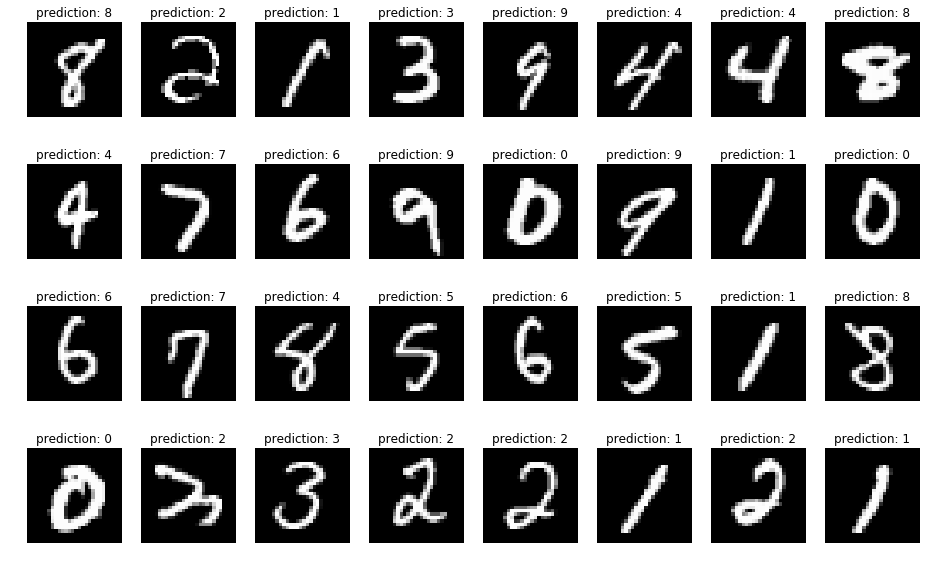

In [4]:
# 테스트 샘플 출력 및 시각화
%matplotlib inline
import matplotlib.pyplot as plt

plot_idx = np.random.randint(0, len(mnist.test.images), 32)

plot_images = mnist.test.images[plot_idx]
plot_labels = mnist.test.labels[plot_idx]
plot_labels = np.argmax(plot_labels, axis=1)

plot_preds = sess.run(pred_op, feed_dict={inputs:plot_images, is_training:False})
plot_preds = np.argmax(plot_preds, axis=1)

fig = plt.figure(figsize=(16, 10))
for i, (img, label, pred) in enumerate(zip(plot_images, plot_labels, plot_preds)):
    a = fig.add_subplot(4, 8, i+1)
    a.set_title("prediction: {}".format(pred))
    a.axis("off")
    plt.imshow(img.reshape(28, 28), cmap="gray")